In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# find most recent date in the data set
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [12]:
# Retreiving the whole data for the past 12 months
sel = [Measurement.date,
       Measurement.prcp]
precip_data = session.query(*sel).\
    filter(func.strftime(Measurement.date) > '2016-08-23').all()
# precip_data

In [13]:
# Create a dataframe to use Matplotlib for a barchart
precip_df = pd.DataFrame(precip_data, columns=['date', 'precip'])
precip_df.shape[0]

2223

In [14]:
# drop NaN values from table
x_df = precip_df.dropna()
# Grouped the data points into the 365 dates
clean_df = x_df.groupby('date')['precip'].sum().to_frame().reset_index()
clean_df['date'] = pd.to_datetime(clean_df.date)

# clean_df.sort('date') # This now sorts in date order
x_df.head()

,date,precip
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01


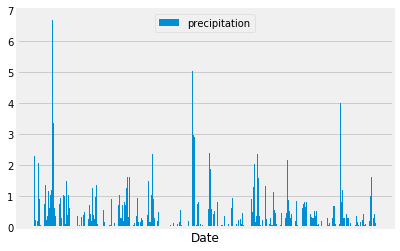

In [39]:
# Create bar graph
x = x_df['date']
y = x_df['precip']
plt.bar(x,y,label='precipitation')
plt.xlabel('Date')
plt.xticks([])
plt.legend(loc='upper center')
plt.show()

In [16]:
# Printing summary statistics from the precipitation data
x_df.describe()

,precip
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [17]:
# query to calculate total number of stations
session.query(Station.station).count()

9

In [18]:
# query to find the  most active stations
sel = [Measurement.station,
       func.count(Measurement.station)]

active_stations = session.query(*sel).\
    group_by(Measurement.station).all()
active_stations

[('USC00511918', 1979),
 ('USC00513117', 2709),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00517948', 1372),
 ('USC00518838', 511),
 ('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00519523', 2669)]

In [19]:
station_df = pd.DataFrame(active_stations, columns=['station','observations'])
station_df

,station,observations
0,USC00511918,1979
1,USC00513117,2709
2,USC00514830,2202
3,USC00516128,2612
4,USC00517948,1372
5,USC00518838,511
6,USC00519281,2772
7,USC00519397,2724
8,USC00519523,2669


In [20]:
# Temperature observation query for last 12 months, only station with most tobs
sel = [
       Measurement.tobs]
top_tobs = session.query(*sel).\
    filter(func.strftime(Measurement.date) > '2016-08-23').\
    filter((Measurement.station) == 'USC00519281').all()
ptps = list(np.ravel(top_tobs))
# ptps

Text(0, 0.5, 'Number of Times Observed')

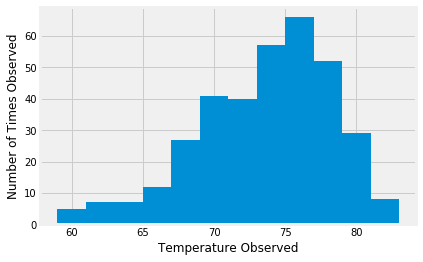

In [21]:
# Plot the ptps list into a bar chart with frequency on y axis
x = ptps
plt.hist(x, bins=12)
plt.xlabel('Temperature Observed')
plt.ylabel('Number of Times Observed')

# Climate App

In [25]:
# Flask Setup
from flask import Flask, jsonify
app = Flask(__name__)